In [1]:
from util.plotting import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, time, timedelta
import json
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
pd.set_option('display.max_columns', None)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'libertine'
plt.rcParams['font.weight'] = 'bold'

## Load outage data

In [16]:
# Load data
path = f'data/clean/outage/2024-08-31/outage_unexploded.csv'
df = pd.read_csv(path, parse_dates=['Date'])
# rename Service
for service in df['Service'].unique():
    if service == "api":
        df.loc[df['Service'] == service, 'Service'] = "API-OpenAI"
    elif service == "chatgpt":
        df.loc[df['Service'] == service, 'Service'] = "ChatGPT"
    elif service == "labs":
        df.loc[df['Service'] == service, 'Service'] = "DALL·E"
    elif service == "playground":
        df.loc[df['Service'] == service, 'Service'] = "Playground"
    elif service == "api.anthropic.com":
        df.loc[df['Service'] == service, 'Service'] = "API-Anthropic"
    elif service == "claude.ai":
        df.loc[df['Service'] == service, 'Service'] = "Claude"
    elif service == "console.anthropic.com":
        df.loc[df['Service'] == service, 'Service'] = "Console"
    elif service == "character.ai":
        df.loc[df['Service'] == service, 'Service'] = "Character.AI"

service_lst = ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']
dfs = {}
# filter by service
for service in service_lst:
    dfs[service] = df[df['Service'] == service]
    dfs[service].reset_index(drop=True, inplace=True)
display(dfs['API-OpenAI'].head())

provider_lst = ['openai', 'anthropic', 'characterai']
dfs_provider = {}
# filter by provider
for provider in provider_lst:
    dfs_provider[provider] = df[df['provider'] == provider]
    dfs_provider[provider].reset_index(drop=True, inplace=True)
display(dfs_provider['openai'].head())

,Date,Outage_Color,Incidents,Service,incident_count,partial_outage_flag,partial_outage_minutes,major_outage_flag,major_outage_minutes,outage_flag,total_outage_minutes,scaled_total_outage_minutes,outage_impact_level,provider
0,2024-06-01,#10a37f,[],API-OpenAI,0,0,0,0,0,0,0,0.0,0,openai
1,2024-06-02,#10a37f,[],API-OpenAI,0,0,0,0,0,0,0,0.0,0,openai
2,2024-06-03,#10a37f,[],API-OpenAI,0,0,0,0,0,0,0,0.0,0,openai
3,2024-06-04,#10a37f,[],API-OpenAI,0,0,0,0,0,0,0,0.0,0,openai
4,2024-06-05,#10a37f,[],API-OpenAI,0,0,0,0,0,0,0,0.0,0,openai


,Date,Outage_Color,Incidents,Service,incident_count,partial_outage_flag,partial_outage_minutes,major_outage_flag,major_outage_minutes,outage_flag,total_outage_minutes,scaled_total_outage_minutes,outage_impact_level,provider
0,2024-06-01,#10a37f,[],DALL·E,0,0,0,0,0,0,0,0.0,0,openai
1,2024-06-02,#10a37f,[],DALL·E,0,0,0,0,0,0,0,0.0,0,openai
2,2024-06-03,#10a37f,[],DALL·E,0,0,0,0,0,0,0,0.0,0,openai
3,2024-06-04,#10a37f,[],DALL·E,0,0,0,0,0,0,0,0.0,0,openai
4,2024-06-05,#10a37f,[],DALL·E,0,0,0,0,0,0,0,0.0,0,openai


In [17]:
# calculate "daily_availability" column
for service in service_lst:
    df = dfs[service]
    df['daily_availability'] = 1 - df['total_outage_minutes'] / (24 * 60)
    df['scaled_daily_availability'] = 1 - df['scaled_total_outage_minutes'] / (24 * 60)
    df['daily_availability'] = df['daily_availability'] * 100
    df['scaled_daily_availability'] = df['scaled_daily_availability'] * 100

dfs['API-OpenAI'].head()

# display the min daily availability in 2 decimal places
print("Min daily availability:")
for service in service_lst:
    df = dfs[service]
    min_availability = df['daily_availability'].min()
    print(f"{service}: {min_availability:.2f}%")

# display the min scaled daily availability in 2 decimal places
print()
print("Min scaled daily availability:")
for service in service_lst:
    df = dfs[service]
    min_availability = df['scaled_daily_availability'].min()
    print(f"{service}: {min_availability:.2f}%")


Min daily availability:
API-OpenAI: 70.35%
ChatGPT: 64.31%
DALL·E: 54.17%
Playground: 80.69%
API-Anthropic: 51.46%
Claude: 41.87%
Console: 41.87%
Character.AI: 59.72%

Min scaled daily availability:
API-OpenAI: 80.57%
ChatGPT: 77.15%
DALL·E: 74.17%
Playground: 82.57%
API-Anthropic: 85.44%
Claude: 82.02%
Console: 82.56%
Character.AI: 85.33%


## fig. daily availability by scaled total outage minutes

In [13]:
# preapre data for heatmap
# creata a dataframe with date from 2021-02-11 to 2024-05-31
start_date = date(2021, 2, 11)
# start_date = date(2023, 2, 1)
end_date = date(2024, 8, 31)
delta = timedelta(days=1)
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta

dates = pd.DataFrame(dates, columns=['Date'])
dates['Date'] = pd.to_datetime(dates['Date'])
dates

# dfs[service] left join dates on 'Date' with only 'daily_availability' column
for service in service_lst:
    df = dfs[service]
    df = pd.merge(dates, df, on='Date', how='left')
    # select only 'Date' and 'daily_availability' columns
    df = df[['Date', 'scaled_daily_availability']]
    dfs[service] = df

# prepare data for plotting
data = {
    'Date': dfs['API-OpenAI']['Date'],
    'API-OpenAI': dfs['API-OpenAI']['scaled_daily_availability'],
    'ChatGPT': dfs['ChatGPT']['scaled_daily_availability'],
    'DALL·E': dfs['DALL·E']['scaled_daily_availability'],
    'Playground': dfs['Playground']['scaled_daily_availability'],
    'API-Anthropic': dfs['API-Anthropic']['scaled_daily_availability'],
    'Claude': dfs['Claude']['scaled_daily_availability'],
    'Console': dfs['Console']['scaled_daily_availability'],
    'Character.AI': dfs['Character.AI']['scaled_daily_availability']
}

df = pd.DataFrame(data)
df

,Date,API-OpenAI,ChatGPT,DALL·E,Playground,API-Anthropic,Claude,Console,Character.AI
0,2021-02-11,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-13,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-14,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-15,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1293,2024-08-27,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
1294,2024-08-28,97.083333,96.583333,100.0,100.0,100.0,100.0,100.0,100.0
1295,2024-08-29,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0
1296,2024-08-30,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0


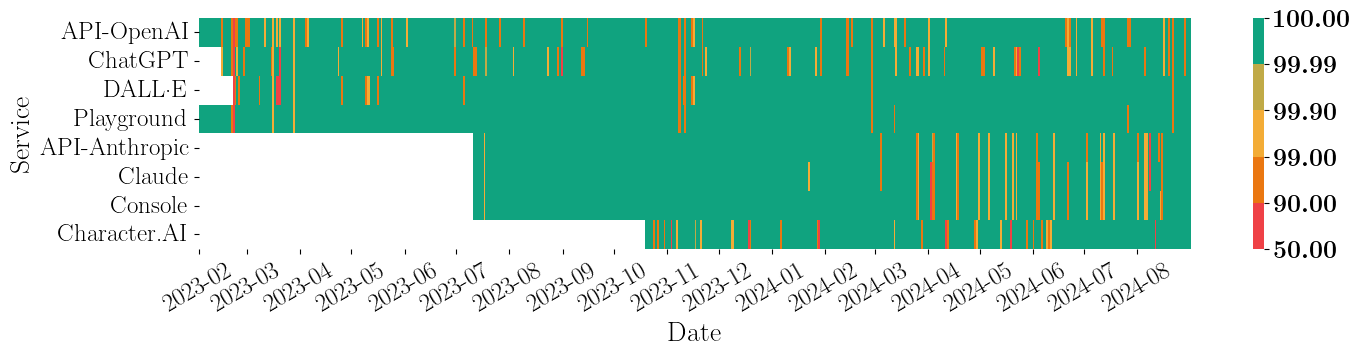

In [79]:
# fig. daily availability by downtime
set_one_column_figure_font(height_multiplier=1.0)

# Melt the DataFrame to have services in one column
df_melted = df.melt(id_vars='Date', var_name='Service', value_name='Availability', ignore_index=True)

custom_colors = ['#ef4146', '#ea7711', '#f3ac36', '#c0aa47', '#10a37f']
cmap = ListedColormap(custom_colors)
custom_bins = [50, 90, 99, 99.9, 99.99, 100] 
norm = BoundaryNorm(custom_bins, cmap.N)

# Create the heatmap
plt.figure(figsize=(16, 3))
heatmap_data = df_melted.pivot(index="Service", columns="Date", values="Availability")
heatmap_data = heatmap_data.reindex(['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI']) 
mask = heatmap_data.isnull()

sns.heatmap(heatmap_data, cmap=cmap, norm=norm, annot=False, fmt=".0f", cbar_kws={'ticks': custom_bins})

# Set x-ticks the start of each month
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='MS')
date_labels = [date.strftime('%Y-%m') for date in date_range]
plt.xticks([heatmap_data.columns.get_loc(date) for date in date_range])
plt.gca().set_xticklabels(date_labels, rotation=30)

plt.savefig('plot/sec5-temporal_analysis/fig-daily_availability_by_scaled_outage_minutes.pdf', bbox_inches='tight')
plt.savefig('plot/sec5-temporal_analysis/fig-daily_availability_by_scaled_outage_minutes.png', bbox_inches='tight')
plt.show()

## table. daily availability by scaled outage minutes

In [14]:
# table. service availability
# create a dataframe with one column for each service
ava_100 = []
ava_99999 = []
ava_9999 = []
ava_999 = []
ava_99 = []
ava_90 = []
ava_50 = []

for service in service_lst:
    df = dfs[service]
    ava_100.append(df[df['scaled_daily_availability'] == 100].shape[0] /  df['scaled_daily_availability'].dropna().shape[0] * 100)
    ava_99999.append(df[df['scaled_daily_availability'] >= 99.999].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)  
    ava_9999.append(df[df['scaled_daily_availability'] >= 99.99].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)
    ava_999.append(df[df['scaled_daily_availability'] >= 99.9].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)
    ava_99.append(df[df['scaled_daily_availability'] >= 99].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)
    ava_90.append(df[df['scaled_daily_availability'] >= 90].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)
    ava_50.append(df[df['scaled_daily_availability'] < 90].shape[0] / df['scaled_daily_availability'].dropna().shape[0] * 100)

data = {
    'Service': ['API-OpenAI', 'ChatGPT', 'DALL·E', 'Playground', 'API-Anthropic', 'Claude', 'Console', 'Character.AI'],
    'Min': [dfs['API-OpenAI']['scaled_daily_availability'].min(), dfs['ChatGPT']['scaled_daily_availability'].min(), dfs['DALL·E']['scaled_daily_availability'].min(), dfs['Playground']['scaled_daily_availability'].min(), dfs['API-Anthropic']['scaled_daily_availability'].min(), dfs['Claude']['scaled_daily_availability'].min(), dfs['Console']['scaled_daily_availability'].min(), dfs['Character.AI']['scaled_daily_availability'].min()],
    'Max': [dfs['API-OpenAI']['scaled_daily_availability'].max(), dfs['ChatGPT']['scaled_daily_availability'].max(), dfs['DALL·E']['scaled_daily_availability'].max(), dfs['Playground']['scaled_daily_availability'].max(), dfs['API-Anthropic']['scaled_daily_availability'].max(), dfs['Claude']['scaled_daily_availability'].max(), dfs['Console']['scaled_daily_availability'].max(), dfs['Character.AI']['scaled_daily_availability'].max()],
    'Mean': [dfs['API-OpenAI']['scaled_daily_availability'].mean(), dfs['ChatGPT']['scaled_daily_availability'].mean(), dfs['DALL·E']['scaled_daily_availability'].mean(), dfs['Playground']['scaled_daily_availability'].mean(), dfs['API-Anthropic']['scaled_daily_availability'].mean(), dfs['Claude']['scaled_daily_availability'].mean(), dfs['Console']['scaled_daily_availability'].mean(), dfs['Character.AI']['scaled_daily_availability'].mean()],
    'Median': [dfs['API-OpenAI']['scaled_daily_availability'].median(), dfs['ChatGPT']['scaled_daily_availability'].median(), dfs['DALL·E']['scaled_daily_availability'].median(), dfs['Playground']['scaled_daily_availability'].median(), dfs['API-Anthropic']['scaled_daily_availability'].median(), dfs['Claude']['scaled_daily_availability'].median(), dfs['Console']['scaled_daily_availability'].median(), dfs['Character.AI']['scaled_daily_availability'].median()],
    '=100%': ava_100,
    '>=99.999%': ava_99999,
    '>=99.99%': ava_9999,
    '>=99.9%': ava_999,
    '>=99%': ava_99,
    '>=90%': ava_90,
    '<90%': ava_50
}

df_table_availability = pd.DataFrame(data)

df_table_availability = df_table_availability.round(2)
for column in df_table_availability.columns:
    if column != 'Service':
        df_table_availability[column] = df_table_availability[column].astype(str) + '%'

df_table_availability

,Service,Min,Max,Mean,Median,=100%,>=99.999%,>=99.99%,>=99.9%,>=99%,>=90%,<90%
0,API-OpenAI,80.57%,100.0%,99.82%,100.0%,92.68%,92.68%,92.68%,92.84%,95.3%,99.77%,0.23%
1,ChatGPT,77.15%,100.0%,99.66%,100.0%,88.85%,88.85%,88.85%,89.2%,93.1%,99.12%,0.88%
2,DALL·E,74.17%,100.0%,99.78%,100.0%,95.88%,95.88%,95.88%,95.88%,96.77%,99.28%,0.72%
3,Playground,82.57%,100.0%,99.94%,100.0%,98.08%,98.08%,98.08%,98.16%,98.88%,99.84%,0.16%
4,API-Anthropic,85.44%,100.0%,99.92%,100.0%,94.02%,94.02%,94.02%,94.26%,97.61%,99.76%,0.24%
5,Claude,82.02%,100.0%,99.84%,100.0%,93.06%,93.06%,93.06%,93.06%,97.13%,99.52%,0.48%
6,Console,82.56%,100.0%,99.89%,100.0%,93.54%,93.54%,93.54%,93.54%,97.61%,99.76%,0.24%
7,Character.AI,85.33%,100.0%,99.59%,100.0%,90.88%,90.88%,90.88%,91.19%,94.03%,98.11%,1.89%


In [15]:
# save the table
df_table_availability.to_csv('plot/backup_table_csv/table-service_availability.csv', index=False)
# to latex
print(df_table_availability.to_latex(index=False)) # copy and let chatgpt add \ before %

\begin{tabular}{llllllllllll}
\toprule
Service & Min & Max & Mean & Median & =100% & >=99.999% & >=99.99% & >=99.9% & >=99% & >=90% & <90% \\
\midrule
API-OpenAI & 80.57% & 100.0% & 99.82% & 100.0% & 92.68% & 92.68% & 92.68% & 92.84% & 95.3% & 99.77% & 0.23% \\
ChatGPT & 77.15% & 100.0% & 99.66% & 100.0% & 88.85% & 88.85% & 88.85% & 89.2% & 93.1% & 99.12% & 0.88% \\
DALL·E & 74.17% & 100.0% & 99.78% & 100.0% & 95.88% & 95.88% & 95.88% & 95.88% & 96.77% & 99.28% & 0.72% \\
Playground & 82.57% & 100.0% & 99.94% & 100.0% & 98.08% & 98.08% & 98.08% & 98.16% & 98.88% & 99.84% & 0.16% \\
API-Anthropic & 85.44% & 100.0% & 99.92% & 100.0% & 94.02% & 94.02% & 94.02% & 94.26% & 97.61% & 99.76% & 0.24% \\
Claude & 82.02% & 100.0% & 99.84% & 100.0% & 93.06% & 93.06% & 93.06% & 93.06% & 97.13% & 99.52% & 0.48% \\
Console & 82.56% & 100.0% & 99.89% & 100.0% & 93.54% & 93.54% & 93.54% & 93.54% & 97.61% & 99.76% & 0.24% \\
Character.AI & 85.33% & 100.0% & 99.59% & 100.0% & 90.88% & 90.88% & 90.88% & 9